In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


2025-04-25 15:22:46.852385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745594567.113792      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745594567.188310      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [44]:
data_dir = '/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data_dir = '/content/drive/MyDrive/project/archive (5)/TrashType_Image_Dataset'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1877 images belonging to 7 classes.
Found 467 images belonging to 7 classes.


In [46]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary form for Keras model training
class_weights_dict = dict(enumerate(class_weights))
print("✅ Computed class weights:", class_weights_dict)


✅ Computed class weights: {0: np.float64(1.8621031746031746), 1: np.float64(0.7801330008312551), 2: np.float64(0.953760162601626), 3: np.float64(0.6572128851540616), 4: np.float64(0.7939932318104906), 5: np.float64(2.8439393939393938)}


In [47]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

# Load pre-trained ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = tf.keras.activations.relu(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  # Adjust to your number of classes

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [49]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = tf.keras.activations.relu(x)
x = Dropout(0.5)(x)

# Automatically get class count
num_classes = train_generator.num_classes
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [52]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1,
    steps_per_epoch=50,          # run only 50 batches per epoch
    validation_steps=10          # only 10 batches of validation
)


Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 591s 12s/step - accuracy: 0.3919 - loss: 2.0107 - val_accuracy: 0.3406 - val_loss: 1.7625
Epoch 2/3
 9/50 ━━━━━━━━━━━━━━━━━━━━ 7:30 11s/step - accuracy: 0.3816 - loss: 1.8773

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.3876 - loss: 1.9021 - val_accuracy: 0.2875 - val_loss: 1.8942
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 597s 12s/step - accuracy: 0.4110 - loss: 1.8933 - val_accuracy: 0.3656 - val_loss: 1.6346


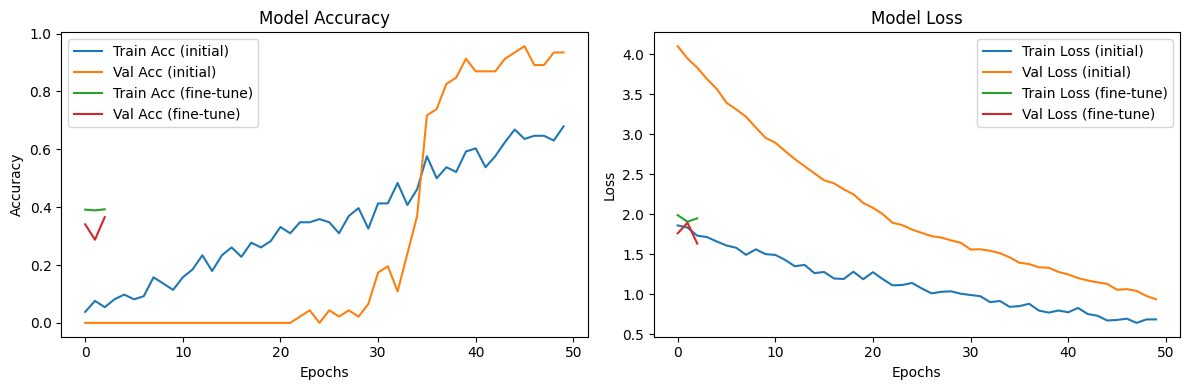

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc (initial)')
plt.plot(history.history['val_accuracy'], label='Val Acc (initial)')
plt.plot(fine_tune_history.history['accuracy'], label='Train Acc (fine-tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Acc (fine-tune)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (initial)')
plt.plot(history.history['val_loss'], label='Val Loss (initial)')
plt.plot(fine_tune_history.history['loss'], label='Train Loss (fine-tune)')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss (fine-tune)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reset the validation generator and make predictions
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())
num_classes = len(labels)

# Print classification report (with all classes)
print("🔍 Classification Report:")
print(classification_report(
    y_true, y_pred,
    labels=list(range(num_classes)),
    target_names=labels,
    zero_division=0  # avoids divide-by-zero error
))

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step
